In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Danmini Doorbell Data Pre-Processing

In [3]:
# Benign traffic

dd_benign = pd.read_csv('nbaiot/Danmini_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_dd_benign = dd_benign.copy(deep=True)

columns = list(df_dd_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1 or column.find('L3') != -1 or column.find('L1') != -1 or column.find('L0.1') != -1:
        chosen_columns.append(column)
        
df_dd_benign = pd.DataFrame(df_dd_benign, columns = chosen_columns)

# Mirai

dd_mirai_ack = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_ack = dd_mirai_ack.copy(deep=True)
df_dd_mirai_ack = pd.DataFrame(df_dd_mirai_ack, columns = chosen_columns)

dd_mirai_scan = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_scan = dd_mirai_scan.copy(deep=True)
df_dd_mirai_scan = pd.DataFrame(df_dd_mirai_scan, columns = chosen_columns)

dd_mirai_syn = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_syn = dd_mirai_syn.copy(deep=True)
df_dd_mirai_syn = pd.DataFrame(df_dd_mirai_syn, columns = chosen_columns)

dd_mirai_udp = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udp = dd_mirai_udp.copy(deep=True)
df_dd_mirai_udp = pd.DataFrame(df_dd_mirai_udp, columns = chosen_columns)

dd_mirai_udpplain = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udpplain = dd_mirai_udpplain.copy(deep=True)
df_dd_mirai_udpplain = pd.DataFrame(df_dd_mirai_udpplain, columns = chosen_columns)

# Bashlite

dd_bashlite_combo = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_combo = dd_bashlite_combo.copy(deep=True)
df_dd_bashlite_combo = pd.DataFrame(df_dd_bashlite_combo, columns = chosen_columns)

dd_bashlite_junk = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_junk = dd_bashlite_junk.copy(deep=True)
df_dd_bashlite_junk = pd.DataFrame(df_dd_bashlite_junk, columns = chosen_columns)

dd_bashlite_scan = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_scan = dd_bashlite_scan.copy(deep=True)
df_dd_bashlite_scan = pd.DataFrame(df_dd_bashlite_scan, columns = chosen_columns)

dd_bashlite_udp = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_udp = dd_bashlite_udp.copy(deep=True)
df_dd_bashlite_udp = pd.DataFrame(df_dd_bashlite_udp, columns = chosen_columns)

dd_bashlite_tcp = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_tcp = dd_bashlite_tcp.copy(deep=True)
df_dd_bashlite_tcp = pd.DataFrame(df_dd_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_dd_benign_norm = scaler.fit_transform(df_dd_benign)

df_dd_miraiack_norm = scaler.fit_transform(df_dd_mirai_ack)
df_dd_miraiscan_norm = scaler.fit_transform(df_dd_mirai_scan)
df_dd_miraisyn_norm = scaler.fit_transform(df_dd_mirai_syn)
df_dd_miraiudp_norm = scaler.fit_transform(df_dd_mirai_udp)
df_dd_miraiudpplain_norm = scaler.fit_transform(df_dd_mirai_udpplain)

df_dd_bashlitecombo_norm = scaler.fit_transform(df_dd_bashlite_combo)
df_dd_bashlitejunk_norm = scaler.fit_transform(df_dd_bashlite_junk)
df_dd_bashlitescan_norm = scaler.fit_transform(df_dd_bashlite_scan)
df_dd_bashliteudp_norm = scaler.fit_transform(df_dd_bashlite_udp)
df_dd_bashlitetcp_norm = scaler.fit_transform(df_dd_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_dd_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_dd_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_dd_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_mirai_ack = df_dd_miraiack_norm
X_test_mirai_scan = df_dd_miraiscan_norm
X_test_mirai_syn = df_dd_miraisyn_norm
X_test_mirai_udp = df_dd_miraiudp_norm
X_test_mirai_udpplain = df_dd_miraiudpplain_norm
X_test_bashlite_combo = df_dd_bashlitecombo_norm
X_test_bashlite_junk = df_dd_bashlitejunk_norm
X_test_bashlite_scan = df_dd_bashlitescan_norm
X_test_bashlite_tcp = df_dd_bashlitetcp_norm
X_test_bashlite_udp = df_dd_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 800
learning_rate = 0.0001
batch_size = 82
anomaly_threshold = 0.042
number_features = 92

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 92)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 46)           4278        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 30)           1410        dense[0][0]                      
__________________________________________________________________________________________________
z_var (Dense)                   (None, 30)           1410        dense[0][0]                      
____________________________________________________________________________________________

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 30)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 46)                1426      
_________________________________________________________________
dense_2 (Dense)              (None, 92)                4324      
Total params: 5,750
Trainable params: 5,750
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 92)]              0         
_________________________________________________________________
encoder (Functional)         (None, 30)                7098      
_________________________________________________________________
decoder (Functional)         (None, 92)                5750      
Total params: 12,848
Trainable params: 12,848
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 34683 samples
Epoch 1/800
34683/34683 [==============================] - 1s 42us/sample - loss: 871.3821
Epoch 2/800
34683/34683 [==============================] - 1s 37us/sample - loss: 89.5453
Epoch 3/800
34683/34683 [==============================] - 1s 37us/sample - loss: 40.9388
Epoch 4/800
34683/34683 [==============================] - 1s 37us/sample - loss: 33.1919
Epoch 5/800
34683/34683 [==============================] - 1s 37us/sample - loss: 28.1585
Epoch 6/800
34683/34683 [==============================] - 1s 37us/sample - loss: 24.3896
Epoch 7/800
34683/34683 [==============================] - 1s 37us/sample - loss: 22.0608
Epoch 8/800
34683/34683 [==============================] - 1s 37us/sample - loss: 19.9997
Epoch 9/800
34683/34683 [==============================] - 1s 37us/sample - loss: 18.0317
Epoch 10/800
34683/34683 [==============================] - 1s 37us/sample - loss: 15.9675
Epoch 11/800
34683/34683 [==============================] - 1s 37us/sample 

34683/34683 [==============================] - 1s 37us/sample - loss: 2.5625
Epoch 182/800
34683/34683 [==============================] - 1s 38us/sample - loss: 2.5551
Epoch 183/800
34683/34683 [==============================] - 1s 37us/sample - loss: 2.5657
Epoch 184/800
34683/34683 [==============================] - 1s 37us/sample - loss: 2.5516
Epoch 185/800
34683/34683 [==============================] - 1s 38us/sample - loss: 2.5487
Epoch 186/800
34683/34683 [==============================] - 1s 37us/sample - loss: 2.5589
Epoch 187/800
34683/34683 [==============================] - 1s 38us/sample - loss: 2.5339
Epoch 188/800
34683/34683 [==============================] - 1s 35us/sample - loss: 2.5374
Epoch 189/800
34683/34683 [==============================] - 1s 38us/sample - loss: 2.5267
Epoch 190/800
34683/34683 [==============================] - 1s 38us/sample - loss: 2.5403
Epoch 191/800
34683/34683 [==============================] - 1s 37us/sample - loss: 2.5436
Epoch 192/800

34683/34683 [==============================] - 1s 38us/sample - loss: 2.2480
Epoch 362/800
34683/34683 [==============================] - 1s 37us/sample - loss: 2.2451
Epoch 363/800
34683/34683 [==============================] - 1s 38us/sample - loss: 2.2384
Epoch 364/800
34683/34683 [==============================] - 1s 38us/sample - loss: 2.2542
Epoch 365/800
34683/34683 [==============================] - 1s 38us/sample - loss: 2.2497
Epoch 366/800
34683/34683 [==============================] - 1s 37us/sample - loss: 2.2513
Epoch 367/800
34683/34683 [==============================] - 1s 38us/sample - loss: 2.2604
Epoch 368/800
34683/34683 [==============================] - 1s 36us/sample - loss: 2.2553
Epoch 369/800
34683/34683 [==============================] - 1s 35us/sample - loss: 2.2361
Epoch 370/800
34683/34683 [==============================] - 1s 37us/sample - loss: 2.2539
Epoch 371/800
34683/34683 [==============================] - 1s 38us/sample - loss: 2.2300
Epoch 372/800

34683/34683 [==============================] - 1s 32us/sample - loss: 2.1315
Epoch 542/800
34683/34683 [==============================] - 1s 31us/sample - loss: 2.1421
Epoch 543/800
34683/34683 [==============================] - 1s 31us/sample - loss: 2.1295
Epoch 544/800
34683/34683 [==============================] - 1s 31us/sample - loss: 2.1307
Epoch 545/800
34683/34683 [==============================] - 1s 31us/sample - loss: 2.1237
Epoch 546/800
34683/34683 [==============================] - 1s 32us/sample - loss: 2.1316
Epoch 547/800
34683/34683 [==============================] - 1s 31us/sample - loss: 2.1315
Epoch 548/800
34683/34683 [==============================] - 1s 31us/sample - loss: 2.1184
Epoch 549/800
34683/34683 [==============================] - 1s 31us/sample - loss: 2.1292
Epoch 550/800
34683/34683 [==============================] - 1s 32us/sample - loss: 2.1273
Epoch 551/800
34683/34683 [==============================] - 1s 31us/sample - loss: 2.1634
Epoch 552/800

34683/34683 [==============================] - 1s 40us/sample - loss: 2.1017
Epoch 722/800
34683/34683 [==============================] - 1s 40us/sample - loss: 2.1076
Epoch 723/800
34683/34683 [==============================] - 1s 40us/sample - loss: 2.0959
Epoch 724/800
34683/34683 [==============================] - 1s 40us/sample - loss: 2.1169
Epoch 725/800
34683/34683 [==============================] - 1s 40us/sample - loss: 2.0970
Epoch 726/800
34683/34683 [==============================] - 1s 40us/sample - loss: 2.0890
Epoch 727/800
34683/34683 [==============================] - 1s 40us/sample - loss: 2.1021
Epoch 728/800
34683/34683 [==============================] - 1s 40us/sample - loss: 2.0950
Epoch 729/800
34683/34683 [==============================] - 1s 40us/sample - loss: 2.0963
Epoch 730/800
34683/34683 [==============================] - 1s 40us/sample - loss: 2.0794
Epoch 731/800
34683/34683 [==============================] - 1s 40us/sample - loss: 2.0963
Epoch 732/800

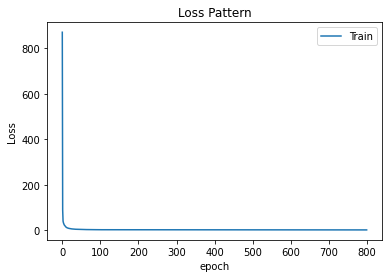

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 38.46349596977234
[False False False ...  True  True  True]


0.9849290626922119

In [15]:
print(len(X_test_VAE))

983615


## Metrics

In [16]:
sys.stdout = open("Results/damini_doorbell.txt", "a")

print(" ==== Test " + str(number_features) + " features - Normal learning rate ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
'''# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)'''

'# Examinig the latent space generated by the encoder\n\nX_encoded = encoder.predict(X_test_VAE)\n\npca = PCA(n_components=2)\nX_analysis = pca.fit_transform(X_encoded)'

In [18]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [19]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [20]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'